In [12]:
import sys
import types
import torch

# Temporary hack to load old checkpoint
import src.model
sys.modules["model"] = src.model

# Load the checkpoint
checkpoint = torch.load("logs/model_5000.pt", map_location=torch.device("cpu"), weights_only=False)

# Now, resave it properly under new structure
torch.save(checkpoint, "logs/model_5000_fixed.pt")

In [1]:
from tiktoken import encoding_for_model
from src.model import GPT2, GPTConfig
import matplotlib.pyplot as plt
import torch

In [2]:
DEVICE = "cpu"

In [4]:
checkpoint = torch.load("logs/model_20000_fixed.pt", map_location=torch.device("cpu"), weights_only=False)

In [5]:
model = GPT2(GPTConfig(vocab_size=50304, n_layer=12, n_head=12, n_embd=768))
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [6]:
enc = encoding_for_model("gpt2")
def generate_token_by_token(model, start, DEVICE, max_length=None):
    x = torch.tensor(enc.encode(start, allowed_special={'<|endoftext|>'}), dtype=torch.long).unsqueeze(0).repeat(1, 1).to(DEVICE)
    ix = torch.tensor([0])
    with torch.no_grad():
        tokens = []
        while ix.item() != enc.eot_token and (max_length is None or len(tokens) < max_length):
            logits, _ = model(x)
            logits = logits[:, -1, :]  # last token
            probs = torch.nn.functional.softmax(logits, dim=-1)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            ix = torch.multinomial(topk_probs, num_samples=1)
            xcol = torch.gather(topk_indices, -1, ix)
            x = torch.cat([x, xcol], dim=1)
            tokens.append(x[:, -1].item())
            yield enc.decode(tokens[-1:])  # yield the last token

In [9]:
start = input("Enter a prompt: ")
if not start:
    start = "<|endoftext|>"
else:
    print(start, end="")
for token in generate_token_by_token(model, start, DEVICE, max_length=32):
    print(token, end="")

Write an essay on Global Warming.
These are really basic ideas on how to write an essay to save you sanity! This is where you have to use the proper format for your essay.

In [11]:
sd = model.state_dict()

for k, v in sd.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50304, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.bias torch.Size([1, 1, 1024, 1024])
transformer.h.0.attn.c_attn.weight torch.Size([2304, 768])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.bias torch.Size([1, 1, 1024, 1024])
transformer.h.1.attn.c_attn.weight torch.Size([2304, 768])
transformer.h.1.attn.c_attn.b

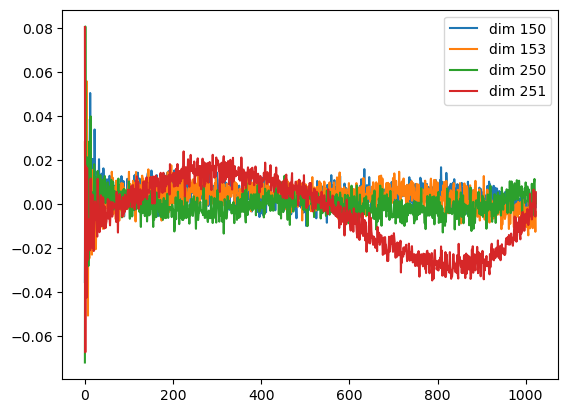

In [17]:
plt.plot(sd["transformer.wpe.weight"][:, 150].tolist(), label="dim 150")
plt.plot(sd["transformer.wpe.weight"][:, 153].tolist(), label="dim 153")
plt.plot(sd["transformer.wpe.weight"][:, 250].tolist(), label="dim 250")
plt.plot(sd["transformer.wpe.weight"][:, 251].tolist(), label="dim 251")
plt.legend()
plt.show()

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import csv

In [14]:
with open("logs/log.csv") as f:
    logs = list(csv.DictReader(f))

steps = np.array([int(row["step"]) for row in logs])
tr = np.array([float(row["train_loss"]) for row in logs])
va = np.array([float(row["val_loss"]) for row in logs])
openaigpt2 = 3.2924

valid = ~np.isnan(va)

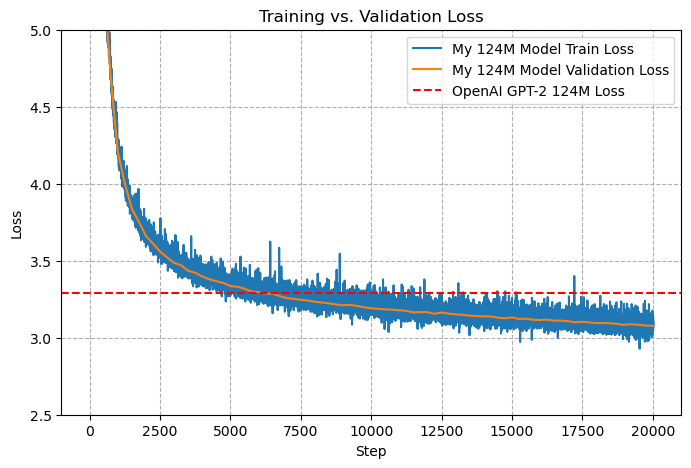

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(steps, tr, label="My 124M Model Train Loss")
plt.plot(steps[valid], va[valid], label="My 124M Model Validation Loss")
plt.axhline(openaigpt2, color="red", linestyle="--", label="OpenAI GPT-2 124M Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.ylim(2.5, 5)
plt.grid(ls="--")
plt.legend()
plt.title("Training vs. Validation Loss")
plt.show()